In [2]:
import pandas as pd

In [1]:
!unzip /content/kaggle.zip

Archive:  /content/kaggle.zip
  inflating: mental_health.csv       


In [3]:
df = pd.read_csv('mental_health.csv')

In [4]:
df.shape

(27977, 2)

In [7]:
df.isnull().sum()

text     0
label    0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

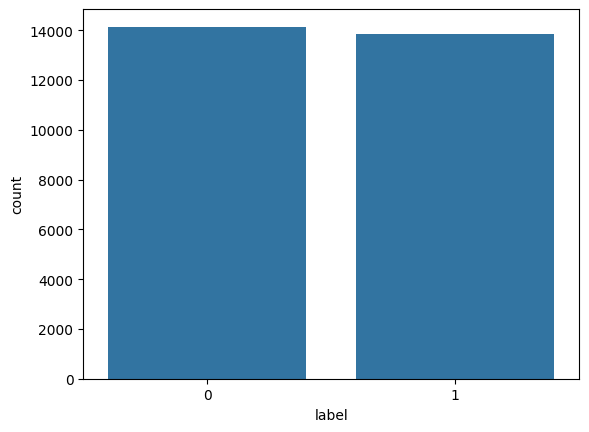

In [9]:
import seaborn as sns
sns.countplot(x='label', data=df)

In [5]:
import re
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [11]:
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [12]:
df['text']=df['text'].apply(data_cleaning)

In [13]:
x = df['text']
y = df['label']

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)

print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

20982 20982
6995 6995


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [17]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [18]:
sequences_matrix

array([[    0,     0,     0, ...,    27,   553,   254],
       [  714,  3538,   797, ...,    58,   589,   270],
       [    0,     0,     0, ..., 11317,    16,  5817],
       ...,
       [  204,     6,     7, ...,   711,   108,    79],
       [ 4431,   168,    18, ...,     6,    44,   251],
       [    0,     0,     0, ...,   752,   528,   898]], dtype=int32)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop

In [33]:
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 300, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [35]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 3,validation_split=0.2)

Epoch 1/3
132/132 [==============================] - 154s 1s/step - loss: 0.4232 - accuracy: 0.8106 - val_loss: 0.2999 - val_accuracy: 0.8992
Epoch 2/3
132/132 [==============================] - 157s 1s/step - loss: 0.2540 - accuracy: 0.9116 - val_loss: 0.4338 - val_accuracy: 0.9009
Epoch 3/3
132/132 [==============================] - 165s 1s/step - loss: 0.2036 - accuracy: 0.9322 - val_loss: 0.2541 - val_accuracy: 0.9099


In [36]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [38]:
test_sequences_matrix

array([[ 3517,  1990,    85, ...,    21,    93,   294],
       [  324,    11,  1125, ...,  6237,   592,  1315],
       [   36,  5785,   330, ...,  8623,   575,  5646],
       ...,
       [    0,     0,     0, ...,  1473,  4805,  1453],
       [    0,     0,     0, ...,   113,   110,   140],
       [    0,     0,     0, ...,     5,    23, 16655]], dtype=int32)

In [39]:
accr = model.evaluate(test_sequences_matrix,y_test)

219/219 [==============================] - 21s 94ms/step - loss: 0.2534 - accuracy: 0.9121


In [40]:
lstm_prediction = model.predict(test_sequences_matrix)

219/219 [==============================] - 22s 99ms/step


In [41]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
print(confusion_matrix(y_test,res))

[[3090  457]
 [ 158 3290]]


In [44]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
import keras

In [47]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [50]:
test = 'im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost  take meds go therapy nothing seems help enough dont want around anymore hate feeling like this wouldnt wish upon enemy brain feels like constantly like static tv wont shut overthinking do think im running options dont see living past  got accepted health science degree dont even know wanna try know im smart mental illness holds back think cant anything im good enough need fucking help dont know anymore ive run options'

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

test=[clean_text(test)]
print(test)

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = load_model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("Normal")
else:
    print("Need expert attention")

im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost  take meds go therapy nothing seems help enough dont want around anymore hate feeling like this wouldnt wish upon enemy brain feels like constantly like static tv wont shut overthinking do think im running options dont see living past  got accepted health science degree dont even know wanna try know im smart mental illness holds back think cant anything im good enough need fucking help dont know anymore ive run options
im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost  take meds go therapy nothing seems help enough dont want around anymore hate feeling like this wouldnt wish upon enemy brain feels like constantly like static tv wont shut overthinking do think im running options dont see living pas